# Sensivity analysis on some dynamic models

*Danilo Lessa Bernardineli (danilo.bernardineli@usp.br)*

This is an exploration of using SALib for studying the behaviour of models.

## Dependences

In [6]:
%load_ext autotime

In [7]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import solve_ivp

time: 2.3 ms


## Logistic map

In [9]:
# Recursive model
@np.vectorize
def logistic_map(X: np.array, a: float) -> np.array:
    return a * X * (1 - X)

def recursive_logistic_map(x: float, a: float, N: int=1) -> float:
    for n in range(N):
        x = logistic_map(x, a)
        yield x

time: 2.05 ms


In [10]:
# Parameters
## Parametric boundaries
problem = {
    'num_vars': 2,
    'names': ['a', 'x'],
    'bounds': [[3.6, 3.9],
               [0.1, 0.9]]
}
param_values = saltelli.sample(problem, 2000)

## Number of recursive steps
N_r = 50

time: 98.3 ms


In [11]:
# Simulation
X = []
for a, x in tqdm(param_values):
    X.append(list(recursive_logistic_map(x, a, N_r)))
X = np.array(X)

100%|██████████| 12000/12000 [00:14<00:00, 852.73it/s]

time: 14.2 s


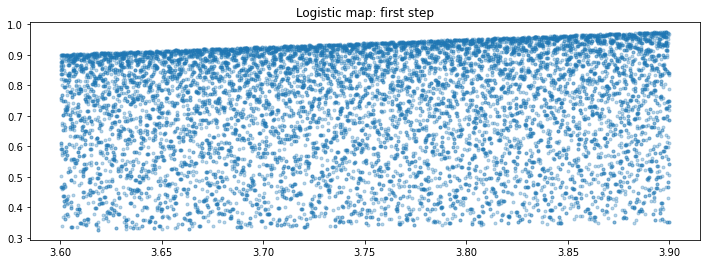

time: 231 ms


In [17]:
plt.figure(figsize=(12, 4))
plt.title("Logistic map: first step")
plt.plot(param_values[:, 0], X[:, 0], '.', alpha=0.3)
plt.show()

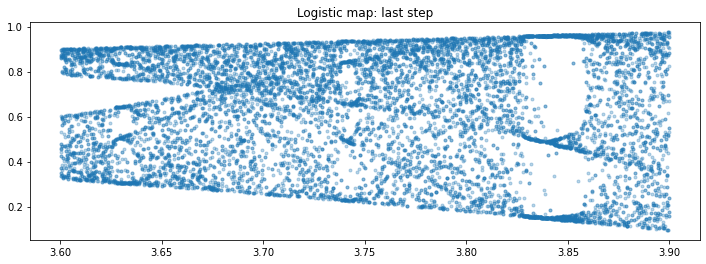

time: 212 ms


In [18]:
plt.figure(figsize=(12, 4))
plt.title("Logistic map: last step")
plt.plot(param_values[:, 0], X[:, -1], '.', alpha=0.3)
plt.show()

### Sensivity analysis

Note that initially essentialy all of the variance is explained by the $x$ variable., however the (a, x) order interactions quickly takes its place when the recursive step increases.

100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


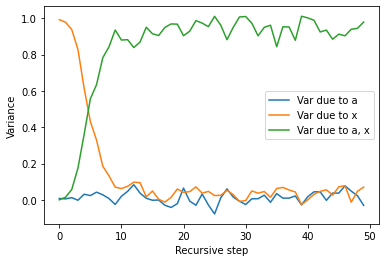

time: 2.36 s


In [22]:
# Sensivity analysis on all timesteps
points = []
for i in tqdm(range(N_r)):
    Si = sobol.analyze(problem, X[:, i])
    points.append((i, *Si['S1'], Si['S2'][0, 1]))
(x, y1, y2, y3) = list(zip(*points))
plt.plot(x, y1, label='Var due to a')
plt.plot(x, y2, label='Var due to x')
plt.plot(x, y3, label='Var due to a, x')
plt.ylabel("Variance")
plt.xlabel("Recursive step")
plt.legend()
plt.show()

## Random

What happens when we simply use an random variable as an output? The answer is that the variables don't explain any variance at all.

In [30]:
problem = {
    'num_vars': 2,
    'names': ['a', 'x'],
    'bounds': [[3.6, 3.9],
               [0.1, 0.9]]
}
param_values = saltelli.sample(problem, 2000)
Y = 100 * np.random.randn(len(param_values))
sobol.analyze(problem, Y, print_to_console=True)
pass

Parameter S1 S1_conf ST ST_conf
a -0.012863 0.061200 0.986725 0.062382
x 0.017539 0.060691 0.957325 0.060431

Parameter_1 Parameter_2 S2 S2_conf
a x -0.001751 0.088205
time: 139 ms


## Fuzzy Linear

In [91]:
problem = {
    'num_vars': 2,
    'names': ['a', 'x'],
    'bounds': [[-3.0, 3.0],
               [-1.0, 1.0]]
}
X = saltelli.sample(problem, 500)
N = len(X)
Y = (X[:, 0] + X[:, 1] * np.random.randn(N))
sobol.analyze(problem, Y, print_to_console=True)
pass

Parameter S1 S1_conf ST ST_conf
a 0.912026 0.105288 1.024332 0.084926
x 0.029872 0.033992 0.103650 0.014178

Parameter_1 Parameter_2 S2 S2_conf
a x 0.001841 0.127570
time: 63.5 ms


## Neuron model

An more complex model is an neuron model consisting of 10 parameters (7 endog., 3 exog.) and 3 variables.

We'll show here what happens when we test 2 parameters for sensivity.

In [94]:
def I(t, I_0, t_0, dt):
    """
    Current impulse function
    """
    if t > t_0:
        if t < t_0 + dt:
            return I_0
    return 0


def neuron(t, X, a, b, c, d, r, s, I_0, t_0, dt, x_1):
    """
    Neuron model
    """
    (x, y, z) = X
    I_t = I(t, I_0, t_0, dt)
    dx = y - a * x ** 3 + b * x ** 2 + I_t - z
    dy = c - d * x ** 2 - y
    dz = r * (s * (x - x_1) - z)
    return (dx, dy, dz)

time: 2.6 ms


In [95]:
# Parameters
problem = {
    'num_vars': 2,
    'names': ['r', 's'],
    'bounds': [[0.0009, 0.0011],
               [3.9, 4.1]]
}
Args = saltelli.sample(problem, 30)
# Parameters
T = (0, 500)
t_eval = np.linspace(T[0], T[1], 2000)

(a, b, c, d) = (1, 3, 1, 5)
(x_1, y_1, z_1) = (-1.6, -11, 2.2)
(I_0, t_0, dt) = (2.0, 200, 300)
neuron_X0 = (x_1, y_1, z_1)

out = []
for args in tqdm(Args):
    args = (a, b, c, d, *args, I_0, t_0, dt, x_1)
    f = solve_ivp(neuron, T, neuron_X0, args=args, t_eval=t_eval)
    out.append((f.t, *f.y))
print("done")

100%|██████████| 180/180 [02:21<00:00,  1.27it/s]

done
time: 2min 21s


### Visualization

This is an snapshot of how the neuron response can be

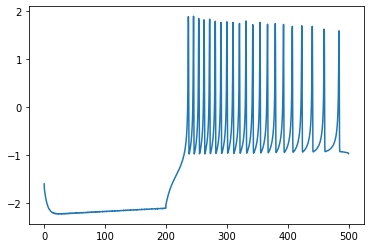

time: 157 ms


In [100]:
M = np.array(out) # (n_arg, n_dim, n_t)
plt.plot(M[50, 0, :], M[50, 1, :])
plt.show()

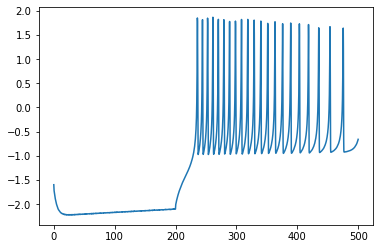

time: 161 ms


In [118]:
M = np.array(out) # (n_arg, n_dim, n_t)
plt.plot(M[0, 0, :], M[0, 1, :])
plt.show()

In [97]:
points = []
for i in tqdm(range(len(t_eval))):
    Si = sobol.analyze(problem, M[:, 1, i])
    points.append((i, *Si['S1'], Si['S2'][0, 1]))

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/usr/local/lib/python3.8/dist-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/usr/local/lib/python3.8/dist-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/usr/local/lib/python3.8/dist-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/usr/local/lib/python3.8/dist-packages/SALib/analyze/sobol.py:153: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0

time: 6.02 s


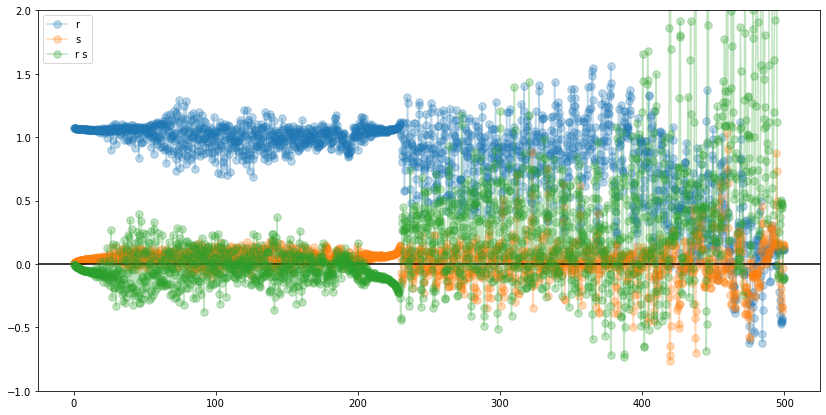

time: 389 ms


In [126]:
plt.figure(figsize=(14, 7))
s = 15
for i, a in enumerate(A[1:-1]):
    plt.plot(M[0, 0, :], a, '.-', label=problem['names'][i], markersize=s, alpha=0.3)
plt.axhline(0, color='k')
plt.plot(M[0, 0, :], A[-1], '.-', markersize=s, label='r s', alpha=0.3)
plt.ylim((-1, 2))
plt.legend()
plt.show()